<a href="https://colab.research.google.com/github/sanster9292/FASTAI_v3_Notebooks/blob/master/lesson3/lesson_3_CamVid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image segmentation with CamVid**


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import * 
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

import matplotlib.pyplot as plt


In [0]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

print(' Path to labels:',path_lbl,'\n','Path to images:', path_img)

 Path to labels: /root/.fastai/data/camvid/labels 
 Path to images: /root/.fastai/data/camvid/images


**Set up data with images and appropriate labels using *get_image_files* to list the full path to the images and their labels.**




In [0]:
img_files = get_image_files(path_img)
img_files[:5]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_08045.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06060.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06180.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f03720.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_009000.png')]

In [0]:
img_lbl = get_image_files(path_lbl)
img_lbl[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_06000_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f03570_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_008700_P.png')]

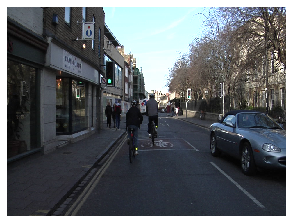

In [0]:
# rand_int = np.random.randint(0, len(img_files))
img_f = img_files[0]
img = open_image(img_f)
# plt.title('the image plotted is',img_files[rand_int])
img.show(figsize=(5,5))

In [0]:
# get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
# get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
get_y_fn = lambda x: path_lbl/f"{x.stem}_P{x.suffix}"

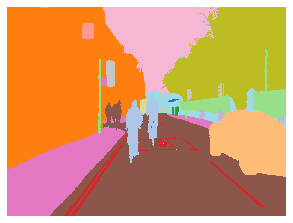

In [0]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize= (5,5), alpha=1)



In [0]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str);codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [0]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")


using bs=8, have 16270MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs, num_workers=0)
       .normalize(imagenet_stats))

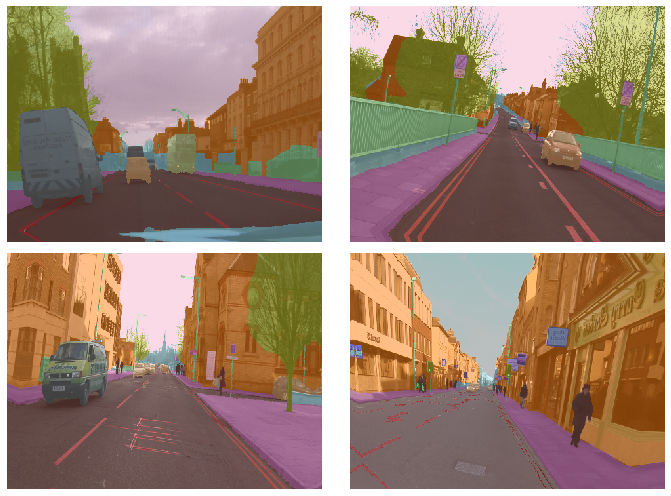

In [0]:
data.show_batch(2, figsize=(10,7))



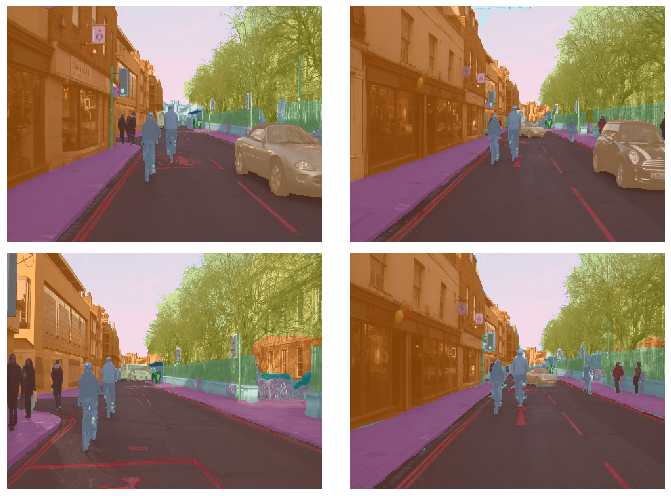

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)


**Training**

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics = acc_camvid
wd = 1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
lr_find(learn)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


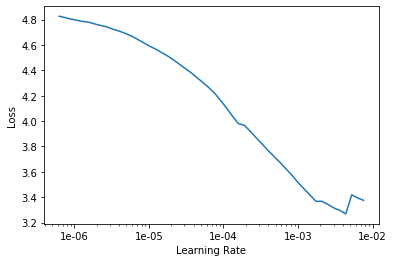

In [0]:
learn.recorder.plot()

In [0]:
lr = 3e-4

In [0]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.95)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.169434,1.414527,0.681398,01:36
1,1.210088,0.786939,0.817392,01:34
2,0.855498,0.636457,0.834283,01:34
3,0.714831,0.550791,0.851419,01:34
4,0.592215,0.445384,0.871674,01:34


In [0]:
learn.save('stage-1')


In [0]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

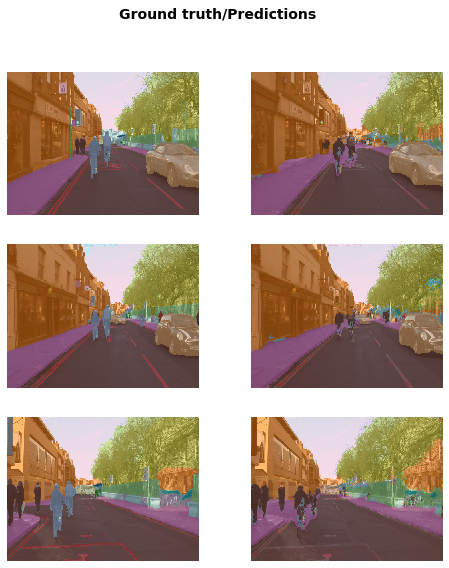

In [0]:
learn.show_results(rows=3, figsize=(8,9))



In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400, lr/4)

In [0]:
learn.fit_one_cycle(10, lrs, pct_start=0.95)


epoch,train_loss,valid_loss,acc_camvid,time
0,0.472827,0.414769,0.880377,01:37
1,0.465764,0.400158,0.882385,01:37
2,0.456374,0.395700,0.885813,01:37
3,0.443843,0.388398,0.887058,01:37
4,0.439286,0.367070,0.894515,01:37
5,0.417331,0.368534,0.891667,01:36
6,0.408073,0.373011,0.891498,01:37
7,0.401067,0.354917,0.895780,01:37
8,0.375471,0.329312,0.902587,01:37
9,0.359280,0.321539,0.904898,01:37


In [0]:
learn.save('stage-2')